In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# import ROOT


In [2]:
# single = '/eos/user/b/bbapi/My_Analysis/Background/a8871225-62a9-4e78-a1a8-c7369ee8c474.root'   
single = "root://xrootd-cms.infn.it///store/mc/Run3Summer23NanoAODv12/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2023_realistic_v14-v2/2520000/fbe0eadb-7f79-4fb0-8077-055d11600eee.root"

In [3]:
factory = NanoEventsFactory.from_root(
    f"{single}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events = ak.materialize(events)

In [4]:
events.fields

['GenVtx',
 'LHEScaleWeight',
 'GenJet',
 'PV',
 'SoftActivityJetNjets2',
 'L1simulation',
 'BeamSpot',
 'HLT',
 'CaloMET',
 'Generator',
 'LHEWeight',
 'SoftActivityJet',
 'GenDressedLepton',
 'GenJetAK8',
 'luminosityBlock',
 'LHEReweightingWeight',
 'GenVisTau',
 'DeepMETResolutionTune',
 'SV',
 'FatJet',
 'LHE',
 'Photon',
 'HTXS',
 'SoftActivityJetHT',
 'SubGenJetAK8',
 'SoftActivityJetHT2',
 'GenIsolatedPhoton',
 'PuppiMET',
 'SoftActivityJetHT10',
 'HLTriggerFinalPath',
 'SoftActivityJetNjets10',
 'GenProton',
 'MET',
 'Electron',
 'L1',
 'OtherPV',
 'IsoTrack',
 'LowPtElectron',
 'DeepMETResponseTune',
 'LHEPdfWeight',
 'RawMET',
 'bunchCrossing',
 'Rho',
 'Muon',
 'TkMET',
 'TrigObj',
 'Pileup',
 'Flag',
 'genWeight',
 'RawPuppiMET',
 'event',
 'ChsMET',
 'CorrT1METJet',
 'SoftActivityJetHT5',
 'Tau',
 'LHEPart',
 'genTtbarId',
 'GenPart',
 'HLTriggerFirstPath',
 'SubJet',
 'Jet',
 'L1Reco',
 'run',
 'FsrPhoton',
 'SoftActivityJetNjets5',
 'GenMET',
 'boostedTau',
 'PSWeight']

In [5]:
events.Photon.fields

['seediEtaOriX',
 'cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'ecalPFClusterIso',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'hoe_PUcorr',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all_quadratic',
 'pfRelIso03_chg_quadratic',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 's4',
 'sieie',
 'sieip',
 'sipip',
 'trkSumPtHollowConeDR03',
 'trkSumPtSolidConeDR04',
 'x_calo',
 'y_calo',
 'z_calo',
 'genPartFlav',
 'genPartIdx',
 'electronIdxG',
 'genPartIdxG',
 'jetIdxG']

In [6]:
photons = events.Photon

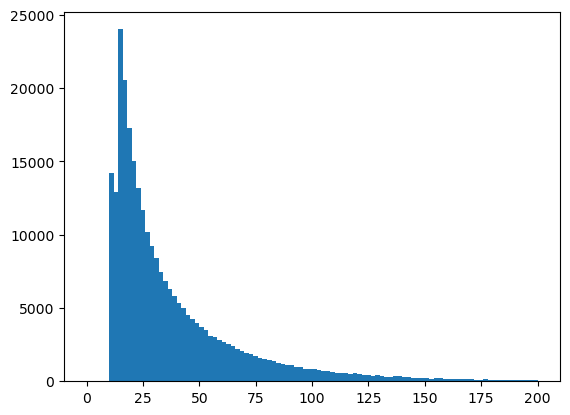

In [7]:
plt.hist(ak.flatten(photons.pt), bins = 100, range = (0,200));

In [24]:
import awkward as ak
import numpy as np

def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)


def photon_preselections_test(
    photons: ak.Array,
    events: ak.Array,
    electron_veto=True,
    revert_electron_veto=False,
    year="2018",
    IsFlag=False):
    """
    Apply full preselection on leptons, jets, and photons.
    Finally return only photons from events that pass all criteria.
    """

    print("Number of events before preselection:", len(events))

    print("Year:", year)

    # ------------------------
    # Lepton selection
    # ------------------------
    if year.startswith("2016"):
        ele_pt_cut, mu_pt_cut = 27, 26
    elif year == "2017":
        ele_pt_cut, mu_pt_cut = 33, 29
    elif year == "2018":
        # ele_pt_cut, mu_pt_cut = 33, 26
        ele_pt_cut, mu_pt_cut = 33, 26

    else:
        raise ValueError(f"Unknown year {year}")
    
    #-------------------------
    # b-tagging working point
    #-------------------------

    if year == "2016APV":
        wp_medium = 0.2598
    elif year == "2016":
        wp_medium = 0.2489
    elif year == "2017":
        wp_medium = 0.304
    elif year == "2018":
        wp_medium = 0.2783

    else:
        raise ValueError(f"Unknown year {year}")


    electrons = events.Electron

    good_electrons = (
        (electrons.pt > ele_pt_cut) &
        (np.abs(electrons.eta) < 2.5) &  # keep within tracker acceptance
        ~((np.abs(electrons.eta) > 1.44) & (np.abs(electrons.eta) < 1.57)) # remove transition
        &(electrons.mvaIso_WP80)    # tight MVA ID
        &(electrons.pfRelIso03_all < 0.15)  # isolation cut
    )

    good_muons = (
        (events.Muon.pt > mu_pt_cut)
        & (np.abs(events.Muon.eta) < 2.4)
        & (events.Muon.pfRelIso03_all < 0.15)
    )

    one_ele = ak.num(events.Electron[good_electrons]) == 1
    one_mu = ak.num(events.Muon[good_muons]) == 1
    lepton_channel_mask = one_ele | one_mu

    # one_or_more_ele = ak.num(events.Electron[good_electrons]) >= 1
    # one_or_more_mu = ak.num(events.Muon[good_muons]) >= 1
    # lepton_channel_mask = one_or_more_ele | one_or_more_mu

    # lepton_channel_mask = one_mu

    selected_electrons = events.Electron[good_electrons]
    print("selected_electrons", len(selected_electrons[ak.num(selected_electrons.pt)>0]))
    selected_muons = events.Muon[good_muons]
    print("selected_muons", len(selected_muons[ak.num(selected_muons.pt)>0]))
    selected_leptons = ak.concatenate([selected_electrons, selected_muons], axis=1)
    print("selected_leptons", len(selected_leptons[ak.num(selected_leptons.pt)>0]))
    print("selected Electrons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==11])>0]))
    print("selected Muons", len(selected_leptons[ak.num(selected_leptons[abs(selected_leptons.pdgId)==13])>0]))

    # ------------------------
    # Jet selection
    # ------------------------
    good_jets = (
        (events.Jet.pt > 20)
        & (np.abs(events.Jet.eta) < 2.4)
        & (events.Jet.btagDeepFlavB > wp_medium)
    )
    selected_bjets = events.Jet[good_jets] 
    print("selected_b_jets: ", selected_bjets)
    at_least_two_bjets = ak.num(selected_bjets) >= 2

    # keep top 2 by DeepJet score
    # top2_bjets = selected_jets[ak.argsort(selected_jets.btagDeepFlavB, ascending=False)][:, :2]

    # ------------------------
    # Photon selection (from photon_preselection output)
    # ------------------------

    abs_eta = np.abs(photons.eta)

    # Barrel–endcap transition exclusion (1.442 ≤ |η| ≤ 1.566)
    valid_eta = (abs_eta <= 2.5) & ~((abs_eta >= 1.442) & (abs_eta <= 1.566))

    # Barrel vs Endcap ID cuts
    is_barrel = abs_eta < 1.442
    is_endcap = (abs_eta > 1.566) & (abs_eta < 2.5)

    # Apply region-specific MVA thresholds
    barrel_cut = is_barrel & (photons.mvaID > -0.02)
    endcap_cut = is_endcap & (photons.mvaID > -0.26)

    # barrel_cut = is_barrel & (photons.mvaID > -0.02)
    # endcap_cut = is_endcap & (photons.mvaID > -0.26)

    # Combine everything
    good_photons = (
        (photons.pt > 10)
        & valid_eta
        & (barrel_cut | endcap_cut)
        & (~photons.pixelSeed)
    )
    selected_photons = photons[good_photons]
    at_least_two_photons = ak.num(selected_photons) >= 2

    dr = delta_r_manual(selected_leptons, selected_photons)
    dr_mask = ak.all(ak.all(dr > 0.4, axis=-1), axis=-1)

    # ΔR between electrons and photons
    dr_electrons = delta_r_manual(selected_electrons, selected_photons)

    # ΔR between muons and photons
    dr_muons = delta_r_manual(selected_muons, selected_photons)


    event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons & dr_mask
    # event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons

    # ------------------------
    # Apply mask — keep length same, empties for failed events
    # ------------------------
    empty_photons = ak.Array([[]] * len(events))
    empty_bjets = ak.Array([[]] * len(events))
    empty_leptons = ak.Array([[]] * len(events))

    filtered_photons = ak.where(event_mask, selected_photons, empty_photons)
    filtered_jets = ak.where(event_mask, selected_bjets, empty_bjets)
    filtered_leptons = ak.where(event_mask, selected_leptons, empty_leptons)


    # filtered_photons = selected_photons[event_mask]
    # filtered_jets = selected_bjets[event_mask]
    # filtered_leptons = selected_leptons[event_mask]
    # filtered_events = events[event_mask]

    return filtered_photons, filtered_jets, filtered_leptons

In [25]:
pho, jets, leps = photon_preselections_test(events.Photon, events)

Number of events before preselection: 195000
Year: 2018
selected_electrons 28588
selected_muons 47097
selected_leptons 75171
selected Electrons 28588
selected Muons 47097
selected_b_jets:  [[{jetId: 6, nConstituents: 30, nElectrons: 0, nMuons: 0, nSVs: 2, ...}], ...]


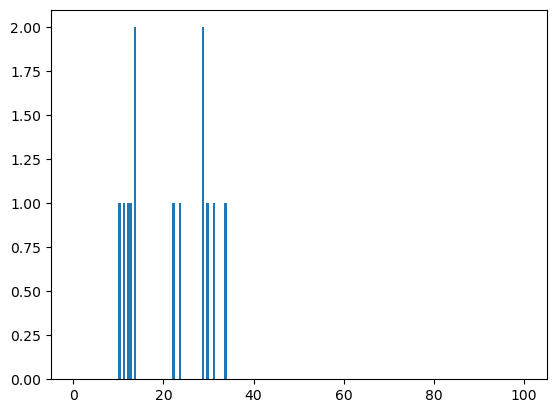

In [26]:
plt.hist(ak.flatten(pho.pt), range = (0, 100), bins = 200);

In [27]:
gen = events.GenPart

In [15]:
gen.fields

['genPartIdxMother',
 'statusFlags',
 'pdgId',
 'status',
 'eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [19]:
gen_photon = gen[gen.pdgId == 22]

In [25]:
gen_photon.genPartIdxMother

<Array [[-1, 29], [13], ..., [44, 44, 58]] type='180000 * var * int16[param...'>

In [28]:
TTG1Jets = ak.from_parquet("/eos/user/b/bbapi/My_Analysis/Background/NTuples_BKG/TTG-1Jets_PTG-10to100_22EESummerRun3/nominal/")

In [2]:
WGtoLNuG = ak.from_parquet('/eos/user/b/bbapi/My_Analysis/Background/NTuples_BKG/WGtoLNuG-1Jets_PTG-10to100_22SummerRun3/nominal')

In [31]:
TTG1Jets.fields

['pholead_seediEtaOriX',
 'pholead_cutBased',
 'pholead_electronVeto',
 'pholead_hasConversionTracks',
 'pholead_isScEtaEB',
 'pholead_isScEtaEE',
 'pholead_mvaID_WP80',
 'pholead_mvaID_WP90',
 'pholead_pixelSeed',
 'pholead_seedGain',
 'pholead_electronIdx',
 'pholead_jetIdx',
 'pholead_seediPhiOriY',
 'pholead_vidNestedWPBitmap',
 'pholead_ecalPFClusterIso',
 'pholead_energyErr',
 'pholead_energyRaw',
 'pholead_esEffSigmaRR',
 'pholead_esEnergyOverRawE',
 'pholead_eta',
 'pholead_etaWidth',
 'pholead_haloTaggerMVAVal',
 'pholead_hcalPFClusterIso',
 'pholead_hoe',
 'pholead_hoe_PUcorr',
 'pholead_mvaID',
 'pholead_pfChargedIso',
 'pholead_pfChargedIsoPFPV',
 'pholead_pfChargedIsoWorstVtx',
 'pholead_pfPhoIso03',
 'pholead_pfRelIso03_all_quadratic',
 'pholead_pfRelIso03_chg_quadratic',
 'pholead_phi',
 'pholead_phiWidth',
 'pholead_pt',
 'pholead_r9',
 'pholead_s4',
 'pholead_sieie',
 'pholead_sieip',
 'pholead_sipip',
 'pholead_trkSumPtHollowConeDR03',
 'pholead_trkSumPtSolidConeDR04'

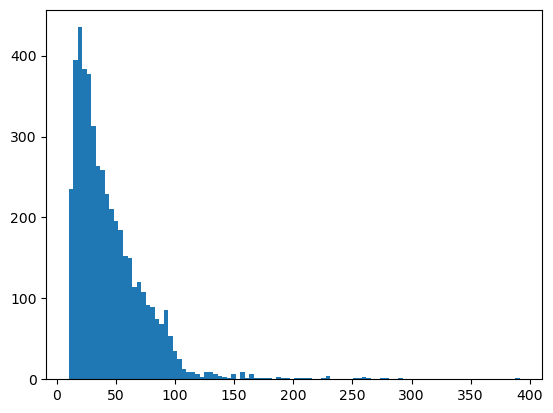

In [33]:
plt.hist(TTG1Jets.pholead_pt, bins = 100);

In [3]:
WGtoLNuG.fields

['pholead_seediEtaOriX',
 'pholead_cutBased',
 'pholead_electronVeto',
 'pholead_hasConversionTracks',
 'pholead_isScEtaEB',
 'pholead_isScEtaEE',
 'pholead_mvaID_WP80',
 'pholead_mvaID_WP90',
 'pholead_pixelSeed',
 'pholead_seedGain',
 'pholead_electronIdx',
 'pholead_jetIdx',
 'pholead_seediPhiOriY',
 'pholead_vidNestedWPBitmap',
 'pholead_ecalPFClusterIso',
 'pholead_energyErr',
 'pholead_energyRaw',
 'pholead_esEffSigmaRR',
 'pholead_esEnergyOverRawE',
 'pholead_eta',
 'pholead_etaWidth',
 'pholead_haloTaggerMVAVal',
 'pholead_hcalPFClusterIso',
 'pholead_hoe',
 'pholead_hoe_PUcorr',
 'pholead_mvaID',
 'pholead_pfChargedIso',
 'pholead_pfChargedIsoPFPV',
 'pholead_pfChargedIsoWorstVtx',
 'pholead_pfPhoIso03',
 'pholead_pfRelIso03_all_quadratic',
 'pholead_pfRelIso03_chg_quadratic',
 'pholead_phi',
 'pholead_phiWidth',
 'pholead_pt',
 'pholead_r9',
 'pholead_s4',
 'pholead_sieie',
 'pholead_sieip',
 'pholead_sipip',
 'pholead_trkSumPtHollowConeDR03',
 'pholead_trkSumPtSolidConeDR04'

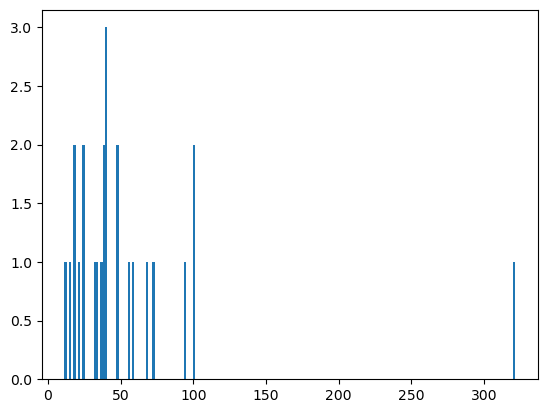

In [7]:
plt.hist(WGtoLNuG.pholead_pt, bins = 200);